# **Speech Classification**

The original tutorial with more details is [here](https://colab.research.google.com/drive/1UwisnAjr8nQF3UnrkIJ4abBMAWzVwBMh?usp=sharing).

## **Model**
In this notebook, we will focus on **ECAPA-TDNN** classifier.

## **Data**
Training will be done on CommonVoice Farsi dataset.


## **Step 0: Drive Mount and SpeechBrain Installation**


Mounting Drive:

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### SpeechBrain Installation
Before starting, let's install speechbrain:

In [2]:
%cd /content/gdrive/MyDrive/SpeakerVerification/

/content/gdrive/MyDrive/SpeakerVerification


In [3]:
%%capture
# Local installation
!git clone https://github.com/speechbrain/speechbrain/
# %cd /content/speechbrain/
# !pip install -r speechbrain/requirements.txt
# !pip install -e speechbrain

In [4]:
%%capture
# For pip installation
!pip install speechbrain

## **Step 1: Preparation**


### Dataset Copy and Extraction

In [5]:
# %cp /content/gdrive/MyDrive/cv/cvfa.tar.gz /content
%cp /content/gdrive/MyDrive/cv/cvfa-resampled.tar.gz /content/cvfa.tar.gz

In [6]:
%cd /content

/content


In [7]:
!tar -xzf cvfa.tar.gz

### Resampling Dataset

In [ ]:
%cd /content/cv-corpus-7.0-2021-07-21/fa

/content/cv-corpus-7.0-2021-07-21/fa


In [ ]:
%%capture
!apt install -y sox libsox-fmt-mp3

In [ ]:
!/content/gdrive/MyDrive/SpeakerVerification/recursive-resample.sh clips resampled

In [ ]:
!cp cvfa-resampled.tar.gz gdrive/MyDrive/cv/

### Cleaning available CSVs

Prepending \{data_root\} to tsv files, adding duration, and converting to csv

In [ ]:
import pandas as pd

In [ ]:
from speechbrain.dataio.dataio import read_audio

from parallel_apply import parallelize

%mkdir -p csvs

SAMPLERATE = 16000
# csvs_path = '/content/gdrive/MyDrive/cv/cv-corpus-7.0-2021-07-21/fa/'
csvs_path = '/content/cv-corpus-7.0-2021-07-21/fa/'

corrupt = 0

def load_none_audio(path):
  # Reading the signal (to retrieve duration in seconds)
  try:
    signal = read_audio(f"{csvs_path}clips/{path}")
    duration = signal.shape[0] / SAMPLERATE
    # return duration if duration >= 3 else None
    return duration
  except:
    global corrupt
    corrupt += 1
    return None

def files_duration(x):
  return x.path.map(load_none_audio)

for file in ['dev.tsv', 'invalidated.tsv', 'other.tsv', 'test.tsv', 'train.tsv', 'validated.tsv']:
  corrupt = 0
  file_path = csvs_path + file
  df = pd.read_csv(file_path, sep='\t', header=0)

  df = df.assign(ID=lambda x: x.path.map(lambda x: x[:-4]))
  df = df.assign(duration=lambda x: parallelize(x, files_duration))
  df = df[df.duration.notnull()]
  
  df = df.rename(columns={"client_id": "spk_id"})
  df = df.filter(items=['ID', 'spk_id', 'path', 'duration'])

  df['path'] = '$data_root/cv-corpus-7.0-2021-07-21/fa/clips/' + df['path'].astype(str)

  df.to_csv(f"csvs/{file.replace('.tsv', '.csv')}", index=False)

  print(f"{file} done.")
  print(f"corrupt: {corrupt}")

dev.tsv done.
corrupt: 0
invalidated.tsv done.
corrupt: 0
other.tsv done.
corrupt: 0
test.tsv done.
corrupt: 0
train.tsv done.
corrupt: 0
validated.tsv done.
corrupt: 0


### Train (Classifcation) Data CSV Preparation

We filter out speakers with less than 10 samples

In [ ]:
df = pd.read_csv(f"csvs/validated.csv", header=0)
df = df.groupby('spk_id').filter(lambda x: len(x) > 10)
print(f"There are {df.groupby('spk_id')['spk_id'].count().shape[0]} speakers with {df.shape[0]} files totally")

There are 1392 speakers with 249713 files totally


In [ ]:
df

,ID,spk_id,path,duration
11826,common_voice_fa_18677719,08f50bb32019a38b85836e6411fa1d2ede0111a3896758...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...,4.716
11827,common_voice_fa_18677720,08f50bb32019a38b85836e6411fa1d2ede0111a3896758...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...,3.708
11828,common_voice_fa_18677721,08f50bb32019a38b85836e6411fa1d2ede0111a3896758...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...,4.212
11829,common_voice_fa_18677722,08f50bb32019a38b85836e6411fa1d2ede0111a3896758...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...,4.212
11830,common_voice_fa_18677723,08f50bb32019a38b85836e6411fa1d2ede0111a3896758...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...,3.888
...,...,...,...,...
261534,common_voice_fa_25247311,02891c7f20efefaece0df2cce7f74e0fedb8bd47d2930a...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...,6.120
261535,common_voice_fa_25247312,02891c7f20efefaece0df2cce7f74e0fedb8bd47d2930a...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...,3.636
261536,common_voice_fa_25247313,02891c7f20efefaece0df2cce7f74e0fedb8bd47d2930a...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...,4.716
261537,common_voice_fa_25247314,02891c7f20efefaece0df2cce7f74e0fedb8bd47d2930a...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...,4.716


In [ ]:
from sklearn.model_selection import train_test_split

train, test_and_dev = train_test_split(df, test_size=0.2)
dev, test = train_test_split(test_and_dev, test_size=0.5)

print(f"train set classes:\t{train.groupby('spk_id').count().shape[0]}")
print(f"dev set classes:\t{dev.groupby('spk_id').count().shape[0]}")
print(f"test set classes:\t{test.groupby('spk_id').count().shape[0]}")

train set classes:	1392
dev set classes:	1269
test set classes:	1271


In [ ]:
%mkdir -p split_csvs
train.to_csv("split_csvs/train.csv", index=False)
dev.to_csv("split_csvs/dev.csv", index=False)
test.to_csv("split_csvs/test.csv", index=False)

### Test (Verification) Data CSV Preparation

In [ ]:
%mkdir -p test_csvs

Getting unseen speakers

In [ ]:
df = pd.read_csv(f"csvs/validated.csv", header=0).filter(items=['spk_id', 'path'])
df = df.groupby('spk_id').filter(lambda x: len(x) <= 10)
print(f"There are {df.groupby('spk_id')['spk_id'].count().shape[0]} speakers with {df.shape[0]} files totally")

There are 2220 speakers with 11826 files totally


In [ ]:
gt_4_df = df.groupby('spk_id').filter(lambda x: 4 <= len(x))
sampled = gt_4_df.groupby('spk_id').sample(4, replace=False)

even = sampled.iloc[::2].rename(columns={"spk_id": "spk_id1", "path": "path1"}).reset_index(drop=True)
odd = sampled.iloc[1::2].rename(columns={"spk_id": "spk_id2", "path": "path2"}).reset_index(drop=True)

pos_new = pd.concat([even, odd], axis=1)
pos_new  # unseen positive class

,spk_id1,path1,spk_id2,path2
0,0015015e8adbf75d017dc4601d6ed146bdf5839320c8ab...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...,0015015e8adbf75d017dc4601d6ed146bdf5839320c8ab...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...
1,0015015e8adbf75d017dc4601d6ed146bdf5839320c8ab...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...,0015015e8adbf75d017dc4601d6ed146bdf5839320c8ab...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...
2,0065c8105de022b3fc004e52e4e783759c417171053dec...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...,0065c8105de022b3fc004e52e4e783759c417171053dec...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...
3,0065c8105de022b3fc004e52e4e783759c417171053dec...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...,0065c8105de022b3fc004e52e4e783759c417171053dec...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...
4,008f853f39967e026d1fab6cca913c85f74f8023656722...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...,008f853f39967e026d1fab6cca913c85f74f8023656722...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...
...,...,...,...,...
3595,ffe9c2a94f109bc918f8ce9ecf25c54303de2dd4479fcb...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...,ffe9c2a94f109bc918f8ce9ecf25c54303de2dd4479fcb...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...
3596,ffeaa4eb40b5eaa2edac6a51560a6782f4ab48cdeaf790...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...,ffeaa4eb40b5eaa2edac6a51560a6782f4ab48cdeaf790...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...
3597,ffeaa4eb40b5eaa2edac6a51560a6782f4ab48cdeaf790...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...,ffeaa4eb40b5eaa2edac6a51560a6782f4ab48cdeaf790...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...
3598,fff095a7ece2c91c97999a91008e71d0227956f5e8b14b...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...,fff095a7ece2c91c97999a91008e71d0227956f5e8b14b...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...


In [ ]:
sampled = df.sample(frac=1)  # shuffles dataset
even = sampled.iloc[::2].rename(columns={"spk_id": "spk_id1", "path": "path1"}).reset_index(drop=True)
odd = sampled.iloc[1::2].rename(columns={"spk_id": "spk_id2", "path": "path2"}).reset_index(drop=True)

neg_new = pd.concat([even, odd], axis=1)
neg_new  # unseen negative class

,spk_id1,path1,spk_id2,path2
0,cc60b3bac521d384fdb6111000890c9b3eb462e32ada03...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...,71e8d9f2f761239c5c5fb563791cf19ab0f8df9bab6373...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...
1,e177e263a02b4bfc829dcc8b487a649a3b054656e116ce...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...,4dbf9e7b7781317487304504ab43a84fdf42612ae11c0b...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...
2,2bf1af812992ffd12cb96a8c444891f00937514ea2f6ca...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...,03be5d19d9b63bd8d0101d95585041a62a6ca3a29e06b2...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...
3,c1681e65a2d48ee32c68914c4da6d78a508c66dbf6bff4...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...,3f55e610d2151c24538ff6b6c6afd36c20f1bda9a1d57d...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...
4,2c992f63b4c08cfb300705495accdc97344e1e9a9ad0fb...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...,1b5d2fd595cd68463eb26ae8b62f3ad401de8913e7f197...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...
...,...,...,...,...
5908,cdb64640048855946257bd52ada74f71a74cdb6631a473...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...,ff3c0af73935caefcd346220793c4ebb2ff9579d6ea122...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...
5909,ded8e9da5ea753770a7bb2a9f2bf9ad89cdbbb58038370...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...,538b6a0d95669d32e0dfe99cef201db521f4a16fe85f05...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...
5910,5adb529b7244b34b86bd0332440bff04d83dfc92ebc8dc...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...,4a9955aabaf7a83bc3d7a5d3546e9d56ab40a32e0ee595...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...
5911,6999019d21991c74f57a4ab791f047d813f4bbb29c4aa0...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...,47b2037b337d0337a32472ea476ad675b2c0a8f25a5f62...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...


Getting seen speakers from test dataset

In [ ]:
df = pd.read_csv(f"split_csvs/test.csv", header=0).filter(items=['spk_id', 'path'])
print(f"There are {df.groupby('spk_id')['spk_id'].count().shape[0]} speakers with {df.shape[0]} files totally")

There are 1271 speakers with 24972 files totally


In [ ]:
gt_4_df = df.groupby('spk_id').filter(lambda x: 4 <= len(x))
sampled = gt_4_df.groupby('spk_id').sample(4, replace=False)

even = sampled.iloc[::2].rename(columns={"spk_id": "spk_id1", "path": "path1"}).reset_index(drop=True)
odd = sampled.iloc[1::2].rename(columns={"spk_id": "spk_id2", "path": "path2"}).reset_index(drop=True)

pos_rep = pd.concat([even, odd], axis=1)
pos_rep  # seen positive class

,spk_id1,path1,spk_id2,path2
0,00167b6431064e1588a3df9280b001b0eaba22c58c4943...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...,00167b6431064e1588a3df9280b001b0eaba22c58c4943...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...
1,00167b6431064e1588a3df9280b001b0eaba22c58c4943...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...,00167b6431064e1588a3df9280b001b0eaba22c58c4943...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...
2,00243bfe65b613056abfcfc01852fe62351a6c337b75ed...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...,00243bfe65b613056abfcfc01852fe62351a6c337b75ed...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...
3,00243bfe65b613056abfcfc01852fe62351a6c337b75ed...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...,00243bfe65b613056abfcfc01852fe62351a6c337b75ed...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...
4,0053b80ae4c350231960ab05f751153620bc24c830790d...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...,0053b80ae4c350231960ab05f751153620bc24c830790d...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...
...,...,...,...,...
1295,ff3ae724e3c5a013f5d39b53c8614592060001884c69f7...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...,ff3ae724e3c5a013f5d39b53c8614592060001884c69f7...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...
1296,ffa434cb8dabcae66385763f1aaad4ab5879023015810d...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...,ffa434cb8dabcae66385763f1aaad4ab5879023015810d...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...
1297,ffa434cb8dabcae66385763f1aaad4ab5879023015810d...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...,ffa434cb8dabcae66385763f1aaad4ab5879023015810d...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...
1298,ffdad509e43353599ac3f847d89d39a420a0b0a5d58792...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...,ffdad509e43353599ac3f847d89d39a420a0b0a5d58792...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...


In [ ]:
sampled = df.sample(frac=1)  # shuffles dataset
even = sampled.iloc[::2].rename(columns={"spk_id": "spk_id1", "path": "path1"}).reset_index(drop=True)
odd = sampled.iloc[1::2].rename(columns={"spk_id": "spk_id2", "path": "path2"}).reset_index(drop=True)

neg_rep = pd.concat([even, odd], axis=1)[:1300]
neg_rep  # seen negative class

,spk_id1,path1,spk_id2,path2
0,c47d81ad91939afc915c747c5a6a562cd7a6bd6ba7394c...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...,0d358649ded3baf7f476eeb2ba44fc2cfc195824b0294f...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...
1,cb9a12f7b626240f7d2a81750e611d2c584b1bb8703e2f...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...,cb9a12f7b626240f7d2a81750e611d2c584b1bb8703e2f...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...
2,d9e326521966c7d01f1a1011e73acbf0f194800788904e...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...,0d358649ded3baf7f476eeb2ba44fc2cfc195824b0294f...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...
3,08e132d1adf9e3ff20ec75f6611d5254f51108807c01b6...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...,cb9a12f7b626240f7d2a81750e611d2c584b1bb8703e2f...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...
4,38f0f508ad55d646d91f283275bfcd7d606422f9e55ec2...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...,facf7a272a4d2576458fc366701df52ff9cc0b0836e02a...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...
...,...,...,...,...
1295,290ae5c82cced84ccb718b1cb54f0d2023266fe77d3d25...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...,975cc87153d1e89a89b3cfaaaf86e6a22178b552bd093b...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...
1296,5a0f51c0fb77cd92d4efca6c61357bfad33c053bd2b582...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...,815df4a0b70c2f2a5b2f285defdea4892a71f5d98160bb...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...
1297,0e1c925e551c965ece56a66e117c34492649a3c154f0a8...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...,f8db55703055fc8918fe3c1f559cdb78cbde390adbc45e...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...
1298,ce9c1910c0735f8dba97c211ba8f5cc1c3dfa29aa17f8e...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...,cb9a12f7b626240f7d2a81750e611d2c584b1bb8703e2f...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...


Creating a subset of train set

In [ ]:
df = pd.read_csv(f"split_csvs/train.csv", header=0).filter(items=['spk_id', 'path'])
print(f"There are {df.groupby('spk_id')['spk_id'].count().shape[0]} speakers with {df.shape[0]} files totally")

There are 1392 speakers with 199770 files totally


In [ ]:
gt_4_df = df.groupby('spk_id').filter(lambda x: 4 <= len(x))
sampled = gt_4_df.groupby('spk_id').sample(4, replace=False)[:2000]

even = sampled.iloc[::2].rename(columns={"spk_id": "spk_id1", "path": "path1"}).reset_index(drop=True)
odd = sampled.iloc[1::2].rename(columns={"spk_id": "spk_id2", "path": "path2"}).reset_index(drop=True)

pos_train = pd.concat([even, odd], axis=1)
pos_train  # train positive class

,spk_id1,path1,spk_id2,path2
0,00167b6431064e1588a3df9280b001b0eaba22c58c4943...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...,00167b6431064e1588a3df9280b001b0eaba22c58c4943...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...
1,00167b6431064e1588a3df9280b001b0eaba22c58c4943...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...,00167b6431064e1588a3df9280b001b0eaba22c58c4943...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...
2,00243bfe65b613056abfcfc01852fe62351a6c337b75ed...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...,00243bfe65b613056abfcfc01852fe62351a6c337b75ed...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...
3,00243bfe65b613056abfcfc01852fe62351a6c337b75ed...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...,00243bfe65b613056abfcfc01852fe62351a6c337b75ed...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...
4,0053b80ae4c350231960ab05f751153620bc24c830790d...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...,0053b80ae4c350231960ab05f751153620bc24c830790d...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...
...,...,...,...,...
995,595b8360ee0d15e8b1c05fd6425f3c66040cc9b5dac494...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...,595b8360ee0d15e8b1c05fd6425f3c66040cc9b5dac494...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...
996,59aec59320447a88e4f8a58c05717900decf8a55f920a1...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...,59aec59320447a88e4f8a58c05717900decf8a55f920a1...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...
997,59aec59320447a88e4f8a58c05717900decf8a55f920a1...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...,59aec59320447a88e4f8a58c05717900decf8a55f920a1...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...
998,5a01033b4f23a5d122ab9b5666c807380f4625baf648a6...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...,5a01033b4f23a5d122ab9b5666c807380f4625baf648a6...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...


In [ ]:
sampled = df.sample(frac=1)[:2000]  # shuffles dataset
even = sampled.iloc[::2].rename(columns={"spk_id": "spk_id1", "path": "path1"}).reset_index(drop=True)
odd = sampled.iloc[1::2].rename(columns={"spk_id": "spk_id2", "path": "path2"}).reset_index(drop=True)

neg_train = pd.concat([even, odd], axis=1)
neg_train  # train negative class

,spk_id1,path1,spk_id2,path2
0,ae3416017fdd87759774c5870218897492b490b487451c...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...,b7a4741d18dc0aa973c8d0370f659668b9edb9ee46624e...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...
1,cdeaa82ace1418ac5dd5b612d955ba8949291632a124d7...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...,18d820e765ca91e1317c9389ed4567e952fe84f2ca3bf2...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...
2,02891c7f20efefaece0df2cce7f74e0fedb8bd47d2930a...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...,08e132d1adf9e3ff20ec75f6611d5254f51108807c01b6...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...
3,d9e326521966c7d01f1a1011e73acbf0f194800788904e...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...,3af4c7b4ce13322c744b72f5ece438fc88630515a5b960...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...
4,13cfe4a65ef3b101f373367716ac86515e41e3809da575...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...,d9e326521966c7d01f1a1011e73acbf0f194800788904e...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...
...,...,...,...,...
995,02891c7f20efefaece0df2cce7f74e0fedb8bd47d2930a...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...,6516da9043b7ec881c4926e4ba16910e92cb918fc8ad92...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...
996,d149cb8db68cdc9f7d087d3d1ecee96ef065c749af6fd6...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...,6516da9043b7ec881c4926e4ba16910e92cb918fc8ad92...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...
997,0d358649ded3baf7f476eeb2ba44fc2cfc195824b0294f...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...,1f4f0eb77cbbf60da8dfdc7c90895c1611495b6334acc2...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...
998,c47d81ad91939afc915c747c5a6a562cd7a6bd6ba7394c...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...,2543e37ab831f1c42bcdc2accd4beda86dea3931e95bbc...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...


Concating classes and writing to file

In [ ]:
veri_df = pd.concat([pos_new, neg_new, pos_rep, neg_rep, pos_train, neg_train], ignore_index=True)
veri_df = veri_df.assign(clazz=lambda x: x["spk_id1"] == x["spk_id2"])
veri_df

,spk_id1,path1,spk_id2,path2,clazz
0,0015015e8adbf75d017dc4601d6ed146bdf5839320c8ab...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...,0015015e8adbf75d017dc4601d6ed146bdf5839320c8ab...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...,True
1,0015015e8adbf75d017dc4601d6ed146bdf5839320c8ab...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...,0015015e8adbf75d017dc4601d6ed146bdf5839320c8ab...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...,True
2,0065c8105de022b3fc004e52e4e783759c417171053dec...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...,0065c8105de022b3fc004e52e4e783759c417171053dec...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...,True
3,0065c8105de022b3fc004e52e4e783759c417171053dec...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...,0065c8105de022b3fc004e52e4e783759c417171053dec...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...,True
4,008f853f39967e026d1fab6cca913c85f74f8023656722...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...,008f853f39967e026d1fab6cca913c85f74f8023656722...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...,True
...,...,...,...,...,...
14108,02891c7f20efefaece0df2cce7f74e0fedb8bd47d2930a...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...,6516da9043b7ec881c4926e4ba16910e92cb918fc8ad92...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...,False
14109,d149cb8db68cdc9f7d087d3d1ecee96ef065c749af6fd6...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...,6516da9043b7ec881c4926e4ba16910e92cb918fc8ad92...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...,False
14110,0d358649ded3baf7f476eeb2ba44fc2cfc195824b0294f...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...,1f4f0eb77cbbf60da8dfdc7c90895c1611495b6334acc2...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...,False
14111,c47d81ad91939afc915c747c5a6a562cd7a6bd6ba7394c...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...,2543e37ab831f1c42bcdc2accd4beda86dea3931e95bbc...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...,False


In [ ]:
veri_df.to_csv("test_csvs/veri.csv", index=False)

Writing separately

In [ ]:
pd.concat([pos_new, neg_new]    , ignore_index=True).assign(clazz=lambda x: x["spk_id1"] == x["spk_id2"]).to_csv("test_csvs/new.csv"     , index=False)
pd.concat([pos_rep, neg_rep]    , ignore_index=True).assign(clazz=lambda x: x["spk_id1"] == x["spk_id2"]).to_csv("test_csvs/spk_rep.csv" , index=False)
pd.concat([pos_train, neg_train], ignore_index=True).assign(clazz=lambda x: x["spk_id1"] == x["spk_id2"]).to_csv("test_csvs/data_rep.csv", index=False)

### Imposter List CSV Preparation

In [ ]:
import pandas as pd

In [ ]:
full_df = pd.read_csv('/content/cv-corpus-7.0-2021-07-21/fa/validated.tsv', header=0, sep='\t')
clean_df = pd.read_csv('/content/gdrive/MyDrive/SpeakerVerification/split_csvs/train.csv', header=0)

In [ ]:
full_train_df = full_df[full_df.path.isin(clean_df['ID'].astype(str) + '.mp3')]
full_train_df = full_train_df[full_train_df.gender.isin(['male', 'female'])]
full_sampled_df = full_train_df.groupby('gender').sample(500, replace=False)
clean_sampled_df = clean_df[clean_df.ID.isin(full_sampled_df.path.str[:-4])]
clean_sampled_df.to_csv('/content/gdrive/MyDrive/SpeakerVerification/test_csvs/imposters.csv', index=False)
clean_sampled_df

,ID,spk_id,path,duration
607,common_voice_fa_18593864,d9e4109d6dc5d2b71e20072d9b04ce9c59dd3f381043fa...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...,3.276
676,common_voice_fa_19310422,0d358649ded3baf7f476eeb2ba44fc2cfc195824b0294f...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...,3.348
702,common_voice_fa_19333263,d149cb8db68cdc9f7d087d3d1ecee96ef065c749af6fd6...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...,3.204
986,common_voice_fa_18552153,f696f3f2108b2aebc068fdaf88b68558c75924da77612d...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...,5.148
1207,common_voice_fa_21619582,e03fe543d414521a2470e6fc02f9c2569ce6f44f8eb62e...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...,3.276
...,...,...,...,...
198521,common_voice_fa_22919082,13cfe4a65ef3b101f373367716ac86515e41e3809da575...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...,2.700
198673,common_voice_fa_18596669,e14f5cdb51053eb3120c08054cecadd2795ddda647afc1...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...,6.372
198975,common_voice_fa_21303592,3e40b9edd34405d248fe5c8f716ed6090f1592a32b3bf3...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...,8.820
199373,common_voice_fa_20682943,f75ff965cfbcf1796261a06c983ea8cbb49c38669a0ffe...,$data_root/cv-corpus-7.0-2021-07-21/fa/clips/c...,2.340


## **Step 2: Training**

In [ ]:
%cd /content/gdrive/MyDrive/SpeakerVerification/

/content/gdrive/MyDrive/SpeakerVerification


In [ ]:
!python train_speaker_embeddings.py hparams/train_ecapa_tdnn.yaml \
  --data_folder="/content" \
  --csv_folder="/content/gdrive/MyDrive/SpeakerVerification/split_csvs" \
  --output_folder="!ref /content/gdrive/MyDrive/cv/results/ecapa_augment/<seed>" \
  --number_of_epochs=30 #  --device=cpu

/content/rirs_noises.zip exists. Skipping download
/content/rirs_noises.zip exists. Skipping download
/content/rirs_noises.zip exists. Skipping download
speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: /content/gdrive/MyDrive/cv/results/ecapa_augment/1986
speechbrain.core - Info: ckpt_interval_minutes arg from hparam file is used
speechbrain.core - 21.0M trainable parameters in SpeakerBrain
speechbrain.utils.checkpoints - Loading a checkpoint from /content/gdrive/MyDrive/cv/results/ecapa_augment/1986/save/CKPT+2022-03-06+17-52-52+00
speechbrain.utils.epoch_loop - Going into epoch 29
100% 6243/6243 [1:52:59<00:00,  1.09s/it, train_loss=0.447]
100% 781/781 [00:50<00:00, 15.54it/s]
speechbrain.nnet.schedulers - Changing lr from 9.6e-05 to 9.6e-05
speechbrain.utils.train_logger - epoch: 29, lr: 9.60e-05 - train loss: 4.47e-01 - valid loss: 3.57e-01, valid ErrorRate: 1.74e-02
speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in /content/gdrive/My

## **Step 3: Inference**

Copying best model

In [ ]:
%cd /content/gdrive/MyDrive/SpeakerVerification/

# Create folder for best model
!rm -rf /content/best_model/
!mkdir -p /content/best_model/

# Copy label encoder
!cp /content/gdrive/MyDrive/cv/results/ecapa_augment/1986/save/label_encoder.txt /content/best_model/

# Copy best model
!cp "`ls -td /content/gdrive/MyDrive/cv/results/ecapa_augment/1986/save/CKPT* | tail -1`"/* /content/best_model/

/content/gdrive/MyDrive/SpeakerVerification


**Building mean_var_norm_emb layer**

In [ ]:
!python speaker_verification_cosine.py hparams/verification_ecapa.yaml \
  --pretrain_path="/content/gdrive/MyDrive/cv/ecapa_spkver_17epoch" \
  --data_folder="/content" \
  --csv_folder="/content/gdrive/MyDrive/SpeakerVerification/split_csvs" \
  --output_folder="!ref /content/tmp/ecapa_veri/<seed>" \
  #  --device=cpu

speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: /content/tmp/ecapa_veri/1234
speechbrain.pretrained.fetching - Fetch embedding_model.ckpt: Using existing file/symlink in /content/tmp/ecapa_veri/1234/save/embedding_model.ckpt.
speechbrain.utils.parameter_transfer - Loading pretrained files for: embedding_model
__main__ - Computing enroll/test embeddings...
100% 3122/3122 [02:14<00:00, 23.29it/s]
100% 3122/3122 [02:14<00:00, 23.22it/s]
100% 24972/24972 [17:56<00:00, 23.19it/s]
__main__ - saving mean_var_norm_emb.ckpt to pretrain_path


**Calculating imposter embeddings**

In [ ]:
%rm -rf /content/best_model
%cp -r /content/gdrive/MyDrive/cv/ecapa_spkver_10epoch/ /content/best_model
!python snorm_embeddings.py hparams/snorm.yaml \
  --pretrain_path="/content/best_model" \
  --data_folder="/content" \
  --imposters_csv="/content/gdrive/MyDrive/SpeakerVerification/test_csvs/imposters.csv" \
  --output_folder="!ref /content/tmp/snorm/<seed>" \
  # --device=cpu
%cp /content/best_model/imposter_embeddings.pt /content/gdrive/MyDrive/cv/ecapa_spkver_10epoch/

speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: /content/tmp/snorm/1234
speechbrain.pretrained.fetching - Fetch embedding_model.ckpt: Using existing file/symlink in model_checkpoints/embedding_model.ckpt.
speechbrain.pretrained.fetching - Fetch mean_var_norm_emb.ckpt: Using existing file/symlink in model_checkpoints/mean_var_norm_emb.ckpt.
speechbrain.utils.parameter_transfer - Loading pretrained files for: embedding_model, mean_var_norm_emb
__main__ - computing imposter embeddings...
100% 125/125 [00:05<00:00, 23.19it/s]
__main__ - saved imposter embeddings on pretrain_path


Writing YAML inference file

In [ ]:
%%writefile /content/best_model/hparams_inference.yaml

# ############################################################################
# Model: ECAPA big for Speaker verification
# ############################################################################

# Feature parameters
n_mels: 80

# Pretrain folder
pretrained_path: /content/best_model

# Output parameters
out_n_neurons: 1392

# Model params
compute_features: !new:speechbrain.lobes.features.Fbank
    n_mels: !ref <n_mels>

mean_var_norm: !new:speechbrain.processing.features.InputNormalization
    norm_type: sentence
    std_norm: False

embedding_model: !new:speechbrain.lobes.models.ECAPA_TDNN.ECAPA_TDNN
    input_size: !ref <n_mels>
    channels: [1024, 1024, 1024, 1024, 3072]
    kernel_sizes: [5, 3, 3, 3, 1]
    dilations: [1, 2, 3, 4, 1]
    attention_channels: 128
    lin_neurons: 192

classifier: !new:speechbrain.lobes.models.ECAPA_TDNN.Classifier
    input_size: 192
    out_neurons: !ref <out_n_neurons>

mean_var_norm_emb: !new:speechbrain.processing.features.InputNormalization
    norm_type: global
    std_norm: False

modules:
    compute_features: !ref <compute_features>
    mean_var_norm: !ref <mean_var_norm>
    embedding_model: !ref <embedding_model>
    mean_var_norm_emb: !ref <mean_var_norm_emb>
    classifier: !ref <classifier>
        
label_encoder: !new:speechbrain.dataio.encoder.CategoricalEncoder

        
pretrainer: !new:speechbrain.utils.parameter_transfer.Pretrainer
    loadables:
        embedding_model: !ref <embedding_model>
        mean_var_norm_emb: !ref <mean_var_norm_emb>
        classifier: !ref <classifier>
        label_encoder: !ref <label_encoder>
    paths:
        embedding_model: !ref <pretrained_path>/embedding_model.ckpt
        mean_var_norm_emb: !ref <pretrained_path>/mean_var_norm_emb.ckpt
        classifier: !ref <pretrained_path>/classifier.ckpt
        label_encoder: !ref <pretrained_path>/label_encoder.txt




Writing /content/best_model/hparams_inference.yaml


### Example files

Test files:

In [ ]:
from verification import SpeakerVerification

verification = SpeakerVerification.from_hparams(source="/content/best_model/", hparams_file='hparams_inference.yaml', savedir="/content/best_model/")

file1 = '/content/gdrive/MyDrive/SpeakerVerification/example/1.mp3'  # Speaker 1
file2 = '/content/gdrive/MyDrive/SpeakerVerification/example/2.mp3'  # Speaker 2
file3 = '/content/gdrive/MyDrive/SpeakerVerification/example/3.mp3'  # Speaker 2

score, prediction = verification.verify_files(file1, file2, threshold = 0.4)
print(f"Different speakers: score: {score.item()}, prediction: {prediction.item()}")  # True = same speaker, False = Different speakers


score, prediction = verification.verify_files(file2, file3, threshold = 0.4)
print(f"Different speakers: score: {score.item()}, prediction: {prediction.item()}")  # True = same speaker, False = Different speakers

Different speakers: score: 0.3186928629875183, prediction: False
Different speakers: score: 0.8086206316947937, prediction: True


In [ ]:
import IPython.display
IPython.display.Audio(file1)

In [ ]:
IPython.display.Audio(file2)

In [ ]:
IPython.display.Audio(file3)

#### Embeddings

In [ ]:
import torchaudio

signal, sample_rate = torchaudio.load('/content/gdrive/MyDrive/SpeakerVerification/example/1.mp3')

# Compute speaker embeddings
embeddings1 = verification.encode_batch(signal)

embeddings1

tensor([[[-9.6491e-01, -5.2446e+00,  7.1536e-01,  2.5403e+00,  2.1163e+00,
          -3.3756e+00,  2.4690e+00,  5.4478e-02, -2.1877e+00,  6.7509e+00,
          -4.2347e+00, -2.3654e+00,  7.1740e+00, -3.5493e+00,  5.7411e-01,
           4.6324e-01,  3.0402e-01,  9.1275e-01,  2.5278e+00, -1.1278e+00,
           2.3600e-01,  5.3000e+00, -8.4210e-01, -2.9465e+00, -4.8829e+00,
           3.1799e-01, -7.4146e+00, -2.7295e+00,  1.6965e+00,  5.7193e+00,
           2.4920e+00,  4.1433e+00,  3.3863e+00,  4.8501e+00, -3.8190e-02,
           1.7056e+00, -1.8226e+00,  8.3284e-01,  7.8550e+00,  7.8862e-01,
           1.4076e+00,  1.5269e+00,  4.8915e+00, -2.2727e+00,  6.1886e+00,
           1.1201e+00,  2.7895e+00,  4.9355e-01,  4.4320e-01,  2.1076e+00,
          -5.3541e+00, -3.4608e+00, -2.7194e+00,  2.6513e+00,  1.4120e+00,
          -2.7338e+00,  4.4614e+00, -6.2882e-01, -2.6308e+00,  5.4511e+00,
          -2.9490e+00, -2.6361e+00, -4.9021e+00,  5.5311e+00, -2.1678e+00,
          -3.2462e+00, -1

In [ ]:
import torchaudio

signal, sample_rate = torchaudio.load('/content/gdrive/MyDrive/SpeakerVerification/example/2.mp3')

# Compute speaker embeddings
embeddings2 = verification.encode_batch(signal)

embeddings2

tensor([[[  0.0284,  -1.8756,  -4.2251,  -0.8231,   7.5653,  -3.5359,  -0.4069,
           -2.0567,  -0.9460,   0.5576,  -4.6830,   0.1333,   4.4626,  -6.2975,
           -0.3812,  -3.5447,   3.1955,  -3.6946,  -2.6152,  -1.6948,   0.7698,
            3.6052,  -4.2568,  -0.7070,   2.3160,   2.5914,  -0.3686,   2.8282,
            3.0700,   1.3133,  -2.7753,   5.1725,  -0.1144,   0.4727,   6.1080,
           -1.7075,   0.5043,   2.8934,   0.9184,   1.3150,  -4.1030,   8.9548,
            4.1876,  -0.7057,   4.5435,  -1.5009,   8.0045,  -5.4921,  -1.0532,
           -1.3813,  -1.6899,  -2.4582,   0.7590,   9.9151,   1.9034,  -9.6527,
           -0.2994,  -5.5290,  -1.6155,  -3.1468,  -0.3300,  -0.5493,   0.8225,
           -1.8765,   1.8786,   2.8299,  -1.0702,   1.6227,   2.4114,  -2.4759,
            1.0187,  -3.5933,   2.4782,  -3.2659,  -0.8304,   4.5197,  -5.0105,
           -2.2730,  -0.7052,   1.4850,   1.3003,  -2.7894,   0.1440,  -0.5852,
            3.0975,   2.7463,  -2.9653, 

In [ ]:
import torchaudio

signal, sample_rate = torchaudio.load('/content/gdrive/MyDrive/SpeakerVerification/example/3.mp3')

# Compute speaker embeddings
embeddings3 = verification.encode_batch(signal)

embeddings3

tensor([[[ 3.0479e+00, -3.5400e+00, -4.5844e+00, -5.9230e-01,  5.7361e+00,
          -2.0861e+00, -4.2261e+00,  1.6377e-01, -7.3831e-02,  1.1155e+00,
          -2.8599e+00,  5.6666e-01,  3.4355e+00, -3.9913e+00,  2.2799e+00,
          -6.2772e+00,  4.0147e+00, -3.1931e+00,  1.7164e-01, -2.0885e+00,
           3.2825e+00,  2.6749e+00, -6.2364e+00,  1.1663e+00, -2.2610e-01,
          -2.8255e+00,  2.6061e+00,  5.9819e-01,  3.1514e+00,  1.6094e-01,
          -9.9959e-02,  2.2957e+00,  1.4664e+00, -4.7767e-01,  6.0731e+00,
          -5.0891e-01, -9.6768e-01,  5.5067e+00, -9.1783e-01,  2.3080e+00,
          -4.2051e+00,  8.3110e+00,  1.1073e+00, -9.3098e-01,  4.8694e+00,
          -1.6544e-01,  5.6517e+00, -2.8034e+00, -1.9401e+00, -2.0272e+00,
          -1.2374e+00, -2.6922e+00,  2.3896e+00,  6.4519e+00,  3.0157e+00,
          -8.1319e+00, -3.0359e+00, -5.2574e+00, -1.3700e+00, -3.7295e+00,
          -2.6469e+00,  3.3941e-01, -5.4378e-01,  2.8230e-01,  3.0203e+00,
           5.5552e+00, -3

In [ ]:
import torch
similarity = torch.nn.CosineSimilarity(dim=-1, eps=1e-6)
print(similarity(embeddings1, embeddings2))
print(similarity(embeddings1, embeddings3))
print(similarity(embeddings2, embeddings3))

tensor([[0.3187]])
tensor([[0.2623]])
tensor([[0.8086]])


### Build Output Normalizer (Legacy)

In [ ]:
%cd /content/gdrive/MyDrive/SpeakerVerification/

/content/gdrive/MyDrive/SpeakerVerification


Load model

In [ ]:
from verification import SpeakerVerification

verification = SpeakerVerification.from_hparams(source="/content/best_model/", hparams_file='hparams_inference.yaml', savedir="/content/best_model/")

Load data file

In [ ]:
import pandas as pd

data_root = '/content'

df = pd.read_csv('split_csvs/dev.csv', header=0).filter(items=['path']).sample(frac=1)
df['path'] = df['path'].str.replace('$data_root', data_root, regex=False)

In [ ]:
df

,path
9870,/content/cv-corpus-7.0-2021-07-21/fa/clips/com...
9558,/content/cv-corpus-7.0-2021-07-21/fa/clips/com...
1491,/content/cv-corpus-7.0-2021-07-21/fa/clips/com...
17751,/content/cv-corpus-7.0-2021-07-21/fa/clips/com...
19098,/content/cv-corpus-7.0-2021-07-21/fa/clips/com...
...,...
22402,/content/cv-corpus-7.0-2021-07-21/fa/clips/com...
19656,/content/cv-corpus-7.0-2021-07-21/fa/clips/com...
18911,/content/cv-corpus-7.0-2021-07-21/fa/clips/com...
8727,/content/cv-corpus-7.0-2021-07-21/fa/clips/com...


Calculating embeddings on 10,000 dev set samples

In [ ]:
import torch
import torchaudio

embeddings = []
for index, row in df[:10000].iterrows():
  signal, _ = torchaudio.load(row['path'])
  # Compute speaker embeddings
  embedding_tensor = verification.encode_batch(signal)
  embeddings.append(embedding_tensor)

In [ ]:
emb_tensor = torch.unsqueeze(torch.cat(embeddings, dim=0), dim=1)
emb_tensor.shape

torch.Size([10000, 1, 1, 192])

In [ ]:
mean_norm = torch.mean(emb_tensor, dim=0)
std_norm = torch.std(emb_tensor, dim=0)

In [ ]:
model_path = '/content/gdrive/MyDrive/cv/ecapa_spkver_model'
torch.save(mean_norm, f"{model_path}/emb_mean_norm.pt")
torch.save(std_norm, f"{model_path}/emb_std_norm.pt")

### Calculate Verifier Accuracy

In [10]:
%cd /content/gdrive/MyDrive/SpeakerVerification/

/content/gdrive/MyDrive/SpeakerVerification


In [11]:
from verification import SpeakerVerification

verification = SpeakerVerification.from_hparams(source="/content/best_model/", hparams_file='hparams_inference.yaml', savedir='/content/tmp/ecapa1')

In [9]:
import pandas as pd

def read_veri_csv(path, data_root='/content'):
  df = pd.read_csv(path, header=0).filter(items=['path1', 'path2', 'clazz']).sample(frac=1)
  df['path1'] = df['path1'].str.replace('$data_root', data_root, regex=False)
  df['path2'] = df['path2'].str.replace('$data_root', data_root, regex=False)
  return df

In [31]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown

def calc_scores(df):
  scores = []
  for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    score, _ = verification.verify_files(row['path1'], row['path2'])
    scores.append(score.item())
  
  return scores

def calc_acc(df, threshold):
  # clazz_counts = df.groupby('clazz').agg({'score': ['count']})['score']['count'].to_dict()
  acc_df = df.assign(correct=lambda x: (x.score > threshold) == (x.clazz))
  return acc_df.correct.sum() / df.shape[0]

def plot_acc_thresh(df, verbose=False):
  x_tresh = []
  y_acc = []
  for thresh in np.arange(2, 16, 0.2):
    acc = calc_acc(df, thresh)
    if verbose:
      print(f"Threshold: {thresh:5.2f}, Accuracy: {acc:5.6f}")
    x_tresh.append(thresh)
    y_acc.append(acc)

  plt.plot(x_tresh, y_acc)
  plt.xlabel('Threshold')
  plt.ylabel('Accuracy')
  plt.savefig('/content/thresh.png')
  plt.show()

def df_acc_stat(df, threshold=10):
  df = df.filter(items=['score', 'clazz'])
  df = df.assign(correct=lambda x: (x.score > threshold) == (x.clazz))
  # print(df.groupby(['clazz', 'same_gender']).agg(['count', 'min', 'max', 'mean', 'std']))
  stat_df = df.groupby('clazz').agg({'correct': ['count', 'sum']})
  stat_df[('correct', 'acc')] = stat_df['correct']['sum'] / stat_df['correct']['count']

  display(Markdown(f"**Threshold: {threshold}**"))
  display(stat_df)
  print(f"\nAcurracy: {df[(df.score > threshold) == (df.clazz)].shape[0] / df.shape[0]}")

In [ ]:
import numpy as np

for thresh in np.arange(0, 12, 0.5):
  print(f"Threshold: {thresh}, Accuracy: {df[(df.score > thresh) == (df.clazz)].shape[0] / df.shape[0]}")

Threshold: 0.0, Accuracy: 0.659
Threshold: 0.5, Accuracy: 0.726
Threshold: 1.0, Accuracy: 0.783
Threshold: 1.5, Accuracy: 0.828
Threshold: 2.0, Accuracy: 0.863
Threshold: 2.5, Accuracy: 0.898
Threshold: 3.0, Accuracy: 0.92
Threshold: 3.5, Accuracy: 0.95
Threshold: 4.0, Accuracy: 0.966
Threshold: 4.5, Accuracy: 0.974
Threshold: 5.0, Accuracy: 0.978
Threshold: 5.5, Accuracy: 0.981
Threshold: 6.0, Accuracy: 0.982
Threshold: 6.5, Accuracy: 0.979
Threshold: 7.0, Accuracy: 0.978
Threshold: 7.5, Accuracy: 0.973
Threshold: 8.0, Accuracy: 0.97
Threshold: 8.5, Accuracy: 0.961
Threshold: 9.0, Accuracy: 0.946
Threshold: 9.5, Accuracy: 0.929
Threshold: 10.0, Accuracy: 0.921
Threshold: 10.5, Accuracy: 0.897
Threshold: 11.0, Accuracy: 0.872
Threshold: 11.5, Accuracy: 0.834


All utterances:

In [26]:
data_root = "/content"

df = read_veri_csv(f"test_csvs/veri.csv")[:5000]
df = df.assign(score=calc_scores)

100%|██████████| 5000/5000 [1:16:06<00:00,  1.09it/s]


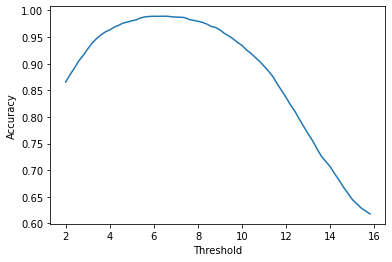

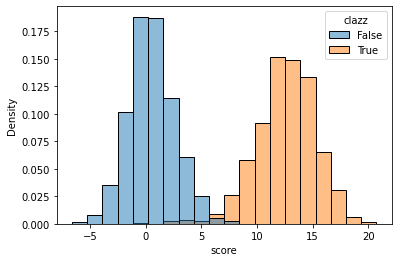

**Threshold: 6**

correct                
        count   sum       acc
clazz                        
False    2875  2850  0.991304
True     2125  2096  0.986353


Acurracy: 0.9892


In [32]:
plot_acc_thresh(df)
sns.histplot(df, x='score', kde=False, hue='clazz', stat="density", common_norm=False)
plt.savefig('/content/hist.png')
plt.show()
df_acc_stat(df, threshold=6)

Unseen speaker (and of course unseen audio):

In [ ]:
data_root = "/content"

df = read_veri_csv(f"test_csvs/new.csv")[:500]
df = df.assign(score=calc_scores)
df_acc_stat(df)

      score                                        
      count       min       max      mean       std
clazz                                              
False   307 -0.267140  0.377188  0.055982  0.114130
True    193  0.105995  0.888331  0.640671  0.126226

Acurracy: 0.984


Seen speaker, unseen audio

In [ ]:
data_root = "/content"

df = read_veri_csv(f"test_csvs/spk_rep.csv")[:500]
df = df.assign(score=calc_scores)
df_acc_stat(df)

      score                                        
      count       min       max      mean       std
clazz                                              
False   246 -0.249646  0.280059 -0.010925  0.091717
True    254  0.186992  0.880942  0.645286  0.119745

Acurracy: 0.99


Seen speaker, seen audio

In [ ]:
data_root = "/content"

df = read_veri_csv(f"test_csvs/data_rep.csv")[:500]
df = df.assign(score=calc_scores)
df_acc_stat(df)

      score                                        
      count       min       max      mean       std
clazz                                              
False   242 -0.324361  0.597569 -0.013020  0.098389
True    258  0.190852  0.902925  0.697238  0.104702

Acurracy: 0.99


## Test

Padding test

In [ ]:
import torchaudio
import random
import torch.nn.functional as F
import IPython.display

snt_len_sample = 3.0 * 16000
duration_sample = int(2.520 * 16000) 
if duration_sample > snt_len_sample:
  start = random.randint(0, duration_sample - snt_len_sample - 1)
  stop = start + snt_len_sample
else:
  start = 0
  stop = duration_sample

num_frames = stop - start
sig, fs = torchaudio.load(
  "/content/cv-corpus-7.0-2021-07-21/fa/clips/common_voice_fa_20442817.mp3", num_frames=num_frames, frame_offset=start
)
sig = sig.transpose(0, 1).squeeze(1)
sig = F.pad(sig, (0, 16000*3 - sig.shape[0]), "constant", 0)
IPython.display.Audio(sig,rate=16000)

In [ ]:
import torchaudio
sig1, fs = torchaudio.load('/content/gdrive/MyDrive/SpeakerVerification/example/1.wav')
sig2, fs = torchaudio.load('/content/gdrive/MyDrive/SpeakerVerification/example/2.wav')

In [ ]:
sig1.shape

torch.Size([1, 64896])

In [ ]:
verification.verify_batch(batch_x, batch_y)

(tensor([[nan]]), tensor([[False]]))

In [ ]:
from speechbrain.pretrained import SpeakerRecognition
verification = SpeakerRecognition.from_hparams(source="speechbrain/spkrec-ecapa-voxceleb", savedir="/content/pretrained_models/spkrec-ecapa-voxceleb")
verification.verify_files("/content/gdrive/MyDrive/SpeakerVerification/example/1.wav", "/content/gdrive/MyDrive/SpeakerVerification/example/2.wav")

(tensor([nan]), tensor([False]))

In [ ]:
import torchaudio

signal1, sample_rate = torchaudio.load('/content/gdrive/MyDrive/SpeakerVerification/example/1.mp3')
signal2, sample_rate = torchaudio.load('/content/gdrive/MyDrive/SpeakerVerification/example/2.mp3')

In [ ]:
print(signal1.shape)
print(signal2.shape)

torch.Size([1, 69120])
torch.Size([1, 49536])


In [ ]:
import torch
import torchaudio

data_root = "/content"
df = pd.read_csv(f"/content/gdrive/MyDrive/SpeakerVerification/split_csvs/veri.csv", header=0).filter(items=['path1', 'path2', 'clazz'])[:100]
df['path1'] = df['path1'].str.replace('\$data_root', data_root)
df['path2'] = df['path2'].str.replace('\$data_root', data_root)

sigs = []

for index, row in df.iterrows():
  signal1, _ = torchaudio.load(row['path1'])
  signal2, _ = torchaudio.load(row['path2'])
  
  sigs.append(signal1)

# torch.cat(sigs)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  import sys


In [ ]:
import torchaudio
torchaudio.load('/content/cv-corpus-7.0-2021-07-21/fa/clips/common_voice_fa_19385659.mp3')

(tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0025, 0.0023, 0.0019]]), 16000)

### SNorm

In [ ]:
%cd /content/gdrive/MyDrive/SpeakerVerification/

/content/gdrive/MyDrive/SpeakerVerification


In [ ]:
%cp -r /content/gdrive/MyDrive/cv/ecapa_spkver_20epoch /content/best_model

In [ ]:
%load_ext autoreload

In [ ]:
%autoreload

In [ ]:
from verification import SpeakerVerification

verification = SpeakerVerification.from_hparams(source="/content/best_model/", hparams_file='hparams_inference.yaml', savedir="/tmp/best_model/")

file1 = '/content/gdrive/MyDrive/SpeakerVerification/example/1.mp3'  # Speaker 1
file2 = '/content/gdrive/MyDrive/SpeakerVerification/example/2.mp3'  # Speaker 2
file3 = '/content/gdrive/MyDrive/SpeakerVerification/example/3.mp3'  # Speaker 2

score, prediction = verification.verify_files(file1, file2, threshold = 0.4, snorm=True)
print(f"Different speakers: score: {score.item()}, prediction: {prediction.item()}")  # True = same speaker, False = Different speakers


score, prediction = verification.verify_files(file2, file3, threshold = 0.4, snorm=True)
print(f"Different speakers: score: {score.item()}, prediction: {prediction.item()}")  # True = same speaker, False = Different speakers

Different speakers: score: 7.7265238761901855, prediction: True
Different speakers: score: 14.730300903320312, prediction: True


In [ ]:
%cp /content/best_model/{hparams_inference.yaml,imposter_embeddings.pt} /content/gdrive/MyDrive/cv/ecapa_spkver_20epoch 

## Parallelization Test

In [ ]:
%cd /content/gdrive/MyDrive/SpeakerVerification/

/content/gdrive/MyDrive/SpeakerVerification


In [ ]:
from speechbrain.pretrained import SpeakerRecognition

verification = SpeakerRecognition.from_hparams(source="/content/best_model/", hparams_file='hparams_inference.yaml', savedir="/content/tmp/spkrec-ecapa-voxceleb")

file1 = '/content/1.mp3'  # Speaker 1
file2 = '/content/2.mp3'  # Speaker 2
file3 = '/content/3.mp3'  # Speaker 2

score, prediction = verification.verify_files(file1, file2)
print(f"Different speakers: score: {score.item()}, prediction: {prediction.item()}")  # True = same speaker, False = Different speakers


score, prediction = verification.verify_files(file2, file3)
print(f"Different speakers: score: {score.item()}, prediction: {prediction.item()}")  # True = same speaker, False = Different speakers

Different speakers: score: 0.4147593080997467, prediction: True
Different speakers: score: 0.7961052060127258, prediction: True


In [ ]:
from pprint import pprint
pprint(vars(verification.hparams.mean_var_norm_emb))


{'_backward_hooks': OrderedDict(),
 '_buffers': OrderedDict(),
 '_forward_hooks': OrderedDict(),
 '_forward_pre_hooks': OrderedDict(),
 '_is_full_backward_hook': None,
 '_load_state_dict_pre_hooks': OrderedDict(),
 '_modules': OrderedDict(),
 '_non_persistent_buffers_set': set(),
 '_parameters': OrderedDict(),
 '_state_dict_hooks': OrderedDict(),
 'avg_factor': None,
 'count': 375,
 'eps': 1e-10,
 'glob_mean': tensor([  5.3246,  -0.7213,  -0.3714, -14.1368,   1.7136, -12.3376,   3.7377,
         -7.2752,   3.9144,  -1.7220,  -3.9573,   2.9182,   8.8691,  -0.4190,
          0.0677,  -1.1944,   0.0535,  -9.2849,   6.2119,  -2.9622,  -2.4762,
         -1.8751,   2.1904,   3.6819,  14.5544,   4.9013,  -4.7762,   8.9328,
         -2.7673, -16.8387,  -2.3638,  -6.0975,  10.0655,  -5.2836,  -1.8729,
          2.7352,   0.2977,  -1.3804,  -0.0599,   1.5350,   1.7019,  -0.4118,
          2.4116,  -9.5530,   0.5611,   2.1914,   3.4324,  -1.7993,   3.1532,
          2.7510,  18.6100,  -1.2109,  -